In [ ]:
!python3 --version

!pip install import-ipynb
!pip install -U -q PyDrive

!pip install transformers
!pip install datasets

In [2]:
from google.colab import drive; drive.mount('/content/drive')

import pdb
import import_ipynb
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

constants_module = drive.CreateFile({'id':''})
constants_module.GetContentFile('constants.ipynb')

utils_module = drive.CreateFile({'id':''})
utils_module.GetContentFile('utils.ipynb')

data_analysis_module = drive.CreateFile({'id':''})
data_analysis_module.GetContentFile('data_analysis.ipynb')

Mounted at /content/drive


In [ ]:
from constants import MODEL_PATH, CHECK_PATH, RANDOM_SEED
from utils import process_regex, process_stopwords
from data_analysis import df_train, df_valid, df_test, MAX_LEN

In [4]:
import torch
from datasets import Dataset, Value, ClassLabel, Features
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

Seteo seeds solo para reproductibildiad, luego las elimino.

In [5]:
torch.manual_seed(RANDOM_SEED)

# **Sobre Hugging Face, transformers y fine tuning**
<p align='justify'>La idea principal detrás del uso de la librería Hugging Face es la implementación de los modelos de transformers que la librería proporciona. Estos transformers pueden ser usados para realizar aprendizaje por transferencia, es decir, importar algún modelo transformer que la librería ponga a disposición, entrenarlo y a este modelo adicionar alguna arquitectura propia (o no, según sea el caso), a la cual se le "transferirán" los pesos que se entrenen en el transformer.</p>

<p align='justify'>La categoría "fine tuning" refiere a la circunstacia donde se usa una red neuronal para inicializar los pesos que implementará otra red neuronal. Existen diferentes técnicas para perfeccionar esta "transferencia" de pesos. Para nuestro caso, la única técnica que implementaremos será la de drop out que, de hecho, ya la incorpora por defecto la clase que usaremos para aplicar el transformer.</p>

<p align='justify'>Vamos a implementar el transformer <i>Beto</i> y el transformer <i>Ruperta</i>, ambos entrenados en base a un corpus en español. La arquitectura de <i>Beto</i> está basada en la arquitectura original de <i>Bert</i>, y fue entrenada con 300 millones de oraciones. La arquitectura de <i>Ruperta</i> está basada en la arquitectura de <i>Roberta</i>, una optimización de <i>Bert</i>, y fue entrenada con 125 millones de oraciones.</p>

<p align='justify'>Existen diferentes maneras de implementar los transformers de Hugging Face. Una de ellas es hacerlo a través de las clases <i>AutoModel</i>. Digo "clases" y no "clase" porque existen diferentes clases de este tipo pero todas heredan de la clase padre <i>BaseAutoModel</i>. En simples palabras, la clase <i>AutoModel</i> es capaz de cargar la arquitectura de un transformer específicos si es que le pasamos como parámetro el path donde este transformer se encuentre.</p>

<p align='justify'>Para nuestro caso de análisis de sentimientos, vamos a implementar <i>Beto</i> y <i>Ruperta</i> a través de la clase <i>AutoModelForSequenceClassification</i>. Además de cargar la arquitectura del transoformer (y entrenarlo), esta clase también adiciona una DNN a la salida del transformer la cual nos permite clasificar en una n cantidad de clases los inputs que esta DNN reciba. Los inputs de la DNN los obtendremos, por supuestos, del dataset de comentarios etiquetados, donde las clases son 0 y 1.</p><br/>

**Más información sobre Bert y Roberta:**

*   *http://jalammar.github.io/illustrated-bert/*
*   *https://huggingface.co/transformers/model_doc/bert.html*
*   *https://huggingface.co/transformers/model_doc/roberta.html*


**Más información sobre Beto y Ruperta:**


*   *https://github.com/dccuchile/beto*
*   *https://github.com/mrm8488/RuPERTa-base*


**Más información sobre AutoModel:**


*   *https://huggingface.co/transformers/model_doc/auto.html*

# **Inicialización del transformer para clasificación de texto en español**
<p align='justify'>Dos son las instancias básicas que debemos implementar para poder entrenar correctamente un transformers de Hugging Face: por un lado, importar el modelo de transformers (aquí es donde implementaremos <i>AutoModelForSequenceClassification</i>); por otro, importar el tokenizador que preparará el conjunto de datos para el entrenamiento (y aquí implementaremos <i>AutoTokenizer</i>).</p>

<p align='justify'>El tokenizador es un objeto importante en el mundo de los transformers. Sin entrenar en detalles, podemos decir que cada transformer puede recibir inputs con "arquitecturas" diferentes. Al igual que <i>AutoModel</i> mapea arquitecturas de transformers, <i>AutoTokenizer</i> "mapea" arquitecturas de inputs o, mejor dicho, nos permite cargar un tokenizador acorde al modelo o situación que nos comprometa. Un tokenizador, además de tokenizar una cadena de entrada, crea los tensores necesarios para el entrenamiento y adiciona tokens especiales (también llamados "limitadores").</p>

<p align='justify'>Lo primero que hacemos es cargar el modelo de transformer a través <i>AutoModelForSequenceClassification</i>. Vamos a setear los siguientes parámetros:</p>

1.   <i>pretrained_model_name_or_path</i>: el path donde se encuentra el transformer.
2.   <i>num_labels</i>: la cantidad labels que deberá aprender a clasificar. En la arquitectura del modelo se consolidan como la cantidad de salidas que tendrá la DNN que acomplamos al transformer.
3.   <i>id2label</i>: ids de las etiquetas mapeadas al nombre de cada etiqueta (0 = "N").
4.   <i>label2id</i>: nombre de las etiquetas mapeadas a un id ("N" = 0).
5.   <i>hidden_dropout_prob</i>: cantidad porcentual de neuronas que deseamos ocultar cuando aplicamos dropout.
6.   <i>return_dict</i>: que el retorno del modelo sea en forma de diccionario en lugar de tupla.

<p align='justify'>Solo para aclarar, tengamos en cuenta que parámetro propio de la clase <i>AutoModelForSequenceClassification</i> solo es el primero, en tanto que los demás son parámetros de la clase <i>PretrainedConfig</i>, la cual nos permite configurar la inicialización del modelo.</p>

<p align='justify'>Por último, vamos a configurar <i>device</i> de PyTorch. Simplemente, es un argumento que permite indicar dónde es que se va a llevar a cabo el procesamiento datos, ya sea el entrenamiento, la evaluación, el testeo o cualquier otro tipo de operación, es decir, permite apuntar a la unidad de cálculo que procesará las operaciones (CPU, GPU o TPU). Tal cual indica la documentación oficial, vamos a utilizarlo para indicar que si no estamos trabajando sobre una GPU, por defecto, utilicemos la CPU de nuestra máquina (la de Colab en este caso).</p><br/>


**Más información sobre Configuration:**

*   *https://huggingface.co/transformers/main_classes/configuration.html*

**Más sobre torch.device:**

*   *https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device*

In [9]:
PRE_TRAINED_MODEL_BETO = 'dccuchile/bert-base-spanish-wwm-cased'
PRE_TRAINED_MODEL_RUPERTA = 'mrm8488/RuPERTa-base'

id2label = {'NEU':0, 'N': 1, 'P': 2}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
dropout = 0.20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_BETO, 
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id, 
                                                           hidden_dropout_prob=dropout,
                                                           return_dict=True,
                                                           )
model = model.to(device)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

<p align='justify'>Ahora instanciamos el tokenizador. Para ello, nuevamente, le pasamos el path del transformer que estamos implementando.</p><br/>

**Más información sobre Tokenizer y AutoTokenizer:**

*   *https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification*
*   *https://huggingface.co/transformers/main_classes/tokenizer.html*

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_BETO)

# **Implementación de Hugging Face Datasets**
<p align='justify'>Hugging Face, además de <i>transformers</i>, pone a disposición una segunda librería llamada <i>datasets</i>, la cual nos facilita y agiliza la creación de datasets (entrenamiento, evaluación y testeo). Se trata de una librería liviana de rápido acceso que no impone muchas dificultades al momento de usarla.</p>

<p align='justify'>Para crear un <i>Hugging Face Dataset</i>, debemos, primero, especificar a través de la clase <i>Features</i> cómo se componen la estructura de nuestro corpus de datos (esta información la clase la recibe en forma de diccionario); segundo, crear el dataset directamente implementando la clase <i>Dataset</i> que recibe como primer parámetro el corpus de datos y como segundo parámetro el objeto <i>features</i>. Dado nuestro simple propósito, no hay que hacer nada más complejo. A tener en cuenta que <i>Dataset</i> puede recibir la información de diferente maneras, en nuestro caso, le pasamos un objeto del tipo <i>pandas.DataFrame</i>.</p>

**Más información sobre Hugging Face Datasets:**

*   *https://huggingface.co/docs/datasets/*

In [20]:
text = df_train.columns[0]
label = df_train.columns[1]
columns = [text, label]

In [21]:
features = Features({
    text: Value('string'),
    label: ClassLabel(num_classes=num_labels, names=["NEU", "P", "N"])
})

train_dataset = Dataset.from_pandas(df_train[columns], features=features)
eval_dataset = Dataset.from_pandas(df_valid[columns], features=features)
test_dataset = Dataset.from_pandas(df_test[columns], features=features)

In [ ]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
train_dataset

Dataset({
    features: ['text_withtout_stops', 'label'],
    num_rows: 4609
})

<p align='justify'>La clase AutoTokenizer pueden configurarse diferentes parámetros con los que se inicializará el tokenizador que estemos implementando. De entre los que vamos a configurar, max_length determina a partir de qué longitud se comenzará a aplicar un padding sobre el input de entrada. Por ejemplo, si max_length estipula que la longitud máxima aceptada es de 30 tokens, entonces, si al tokenizador ingresa una cadena de 40 tokens, los últimos 10 serán reemplazados por el token especial PAD.</p>

In [22]:
def tokenize(batch):
    return tokenizer(text=batch["text_withtout_stops"], 
                     max_length=MAX_LEN,
                     padding='max_length', 
                     truncation=True,
                     )

<p align='justify'>Ya con los Hugging Face Datasets en nuestro poder, podemos hacer uso de una serie de atributos y métodos que incorpora el objeto. De entre ellos, vamos a utilizar el método map() para tokenizar los datasets. En realidad, como hemos aclarado, estamos haciendo mucho más que simplemente "tokenizar los datos". El tokenizador de Hugging Face más bien retorna un input codificado para un tipo de transformer determinado. Dado que map(), justamente, mapea una función sobre una estructura de datos, antes de implementar el tokenizador, debemos encapsularlo en una función. Al mismo tiempo, y como lo indica la propia documentación, el método map() puede generar y trabajar sobre batchs de datos. Para ello, simplemente, seteamos batched=True y con batch_size determinamos el tamaño de los batchs.</p></br>

**Más información sobre map():**

- https://huggingface.co/docs/datasets/processing.html#processing-data-with-map

In [24]:
batch_size = 32
eval_batch_size = 8

In [ ]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
eval_dataset = eval_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

  0%|          | 0/145 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

<p align='justify'>Si investigamos un poco un <i>Hugging Face Dataset</i> vamos a encontrarnos con la siguiente información, la cual nos ayudará a comprender mejor qué es lo que hace realmente un tokenizador para un modelo de transformers. El tokenizador no solo tokeniza una entrada, sino que adiciona información de valor para el entrenamiento del modelo, como lo son los tokens especiales y el enmascaramiento.</p>

In [ ]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text_withtout_stops', 'token_type_ids'],
    num_rows: 4609
})

In [ ]:
train_dataset[text][0]

'tanto libro chiva hay buen punto comida entonces'

In [ ]:
train_dataset["label"][0]

2

In [ ]:
train_dataset["input_ids"][0]

[4,
 1877,
 3872,
 9118,
 1406,
 1423,
 1594,
 2307,
 4470,
 2255,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
train_dataset["attention_mask"][0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# **Entrenamiento del transformer**
<p align='justify'>Para entrenar (y también para evaluar) el modelo vamos a implementar dos clases de la librería <i>transformers</i> de Hugging Face: <i>TrainingArguments</i> y <i>Trainer</i>. Tal como indica la documentación oficial, <i>Trainer</i> es una API que abstrae la lógica de entrenamiento simplificando su implementación con unos pocos métodos, en tanto que <i>TrainingArguments</i> permite configurar los argumentos que guiarán dicho entrenamiento.</p>

<p align='justify'>Lo primero que haremos será setear un conjunto de parámetros que recomienda el documento "Attention Is All You Need" para perfeccionar el entrenamiento de un transformer. Este documento fue presentado en el año 2017 y expone la primera implementación de un transformer. Allí se proponen una serie de parámetros de los cuales destacamos:</p>

- Batch size: 16, 32
- Optimizador: Adam
- Learning rates: 5e-5, 3e-5, 2e-5
- Epochs: 2, 3, 4
- Un scheduler para que el learning rate caiga progresivamente durante el entrenamiento

<p align='justify'>Dado que vamos a implimentar <i>TrainingArguments</i>, vale aclarar que muchos de estos parámetros ya están inicializados por esta clase. Por defecto, de los parámetros mencionados, implementa Adam como optimizador, learning rate en 5e-5 y epochs en 3. En tanto que el scheduler debemos implementarlo por nuestra cuenta.</p><br/>

**Más información sobre Hugging Face para clasificación de texto:**

*   *https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb*

**Más información sobre Trainer y TrainingArguments:**

*   *https://huggingface.co/transformers/main_classes/trainer.html*

**Más información sobre Attention Is All You Need y el scheduler:**

*   *https://arxiv.org/abs/1706.03762*
*   *https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634*

In [ ]:
epochs = 3
# learning_rate = 2e-5
warmup_proportion = 0.1 
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

In [ ]:
training_args = TrainingArguments( 
    do_eval=False,
    num_train_epochs=epochs,
    # learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch", # el modelo se evalua lugo de cada epoch
    weight_decay=0.01,
    metric_for_best_model="macro_f1",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


<p align='justify'><i>Trainer</i> facilita la implementación de diferentes métricas para evaluar el rendimiento del modelo. Vamos a calcular accuracy, precision, recall y F1, asi como también mostrar una matriz de confusión. Para implementar estas métricas a través de <i>Trainer</i>, vamos a seguir la documentación oficial de Hugging Face, donde se propone hacerlo con <i>sklearn</i>. Solo adicionaremos unos cambios simples para mostrar la matriz de confunsión.</p>

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_fscore_support, 
                             accuracy_score,)

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)

    target_names = ['neutral', 'negative', 'positive']

    cm = confusion_matrix(labels, preds)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

    print(show_confusion_matrix(df_cm))

    return {
        'accuracy': acc,
        'f1': f1,
        'f1 mean': st.mean(f1),
        'precision mean': st.mean(precision),
        'recall mean': st.mean(recall)
    }

<p align='justify'>Instanciamos <i>Trainer</i> y lo inicializamos:</p>

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [ ]:
# Para debbuguear
# for batch in trainer.get_train_dataloader():
#     break
# batch = {k: v for k, v in batch.items()}
# outputs = trainer.model(**batch)

Entrenamos el modelo simplemente llamando al método que mostramos a continuación. Al terminar, mostrará las métricas que hemos seteado antes.

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running training *****
  Num examples = 4609
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 435


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 mean,Precision mean,Recall mean
1,No log,0.889757,0.656250,[0.51724138 0.74358974 0.67857143],0.646468,0.646429,0.647243
2,No log,0.942398,0.635417,[0.45614035 0.71641791 0.70588235],0.626147,0.636356,0.640685
3,No log,0.835253,0.739583,[0.65671642 0.77142857 0.8 ],0.742715,0.751053,0.743191


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8
Trainer is attempting to log a value of "[0.51724138 0.74358974 0.67857143]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


None


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8
Trainer is attempting to log a value of "[0.45614035 0.71641791 0.70588235]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


None


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8
Trainer is attempting to log a value of "[0.65671642 0.77142857 0.8       ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


None




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=435, training_loss=0.375585902422324, metrics={'train_runtime': 170.9792, 'train_samples_per_second': 80.869, 'train_steps_per_second': 2.544, 'total_flos': 213168118765140.0, 'train_loss': 0.375585902422324, 'epoch': 3.0})

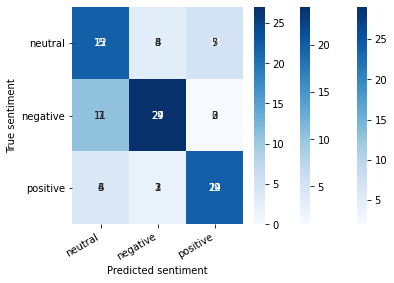

In [ ]:
trainer.train()

Evaluamos el modelo:

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8


Trainer is attempting to log a value of "[0.65671642 0.77142857 0.8       ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


None


{'epoch': 3.0,
 'eval_accuracy': 0.7395833333333334,
 'eval_f1': array([0.65671642, 0.77142857, 0.8       ]),
 'eval_f1 mean': 0.7427149964463396,
 'eval_loss': 0.8352530598640442,
 'eval_precision mean': 0.7510531364698031,
 'eval_recall mean': 0.7431913116123642,
 'eval_runtime': 0.8216,
 'eval_samples_per_second': 116.839,
 'eval_steps_per_second': 14.605}

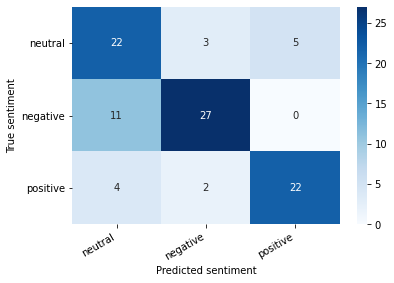

In [ ]:
trainer.evaluate()

Guardamos el modelo:

In [ ]:
trainer.save_model(MODEL_PATH)

# **Resultados de las pruebas de entrenamiento**

<p align='justify'>Cuando realizamos el preprocesado de los datos, creamos un dataset que contenía los mismos datos pero preprocesados de diferentes maneras. Tal así, pudimos llevar a cabo diferentes pruebas para verificar qué conjuntos de datos resultaba más pertienente para nuestro modelo basado en Transformers.</p> 

<p align='justify'>Se trató de una prueba sencilla que se dividió en dos etapas. Durante la <b>primera etapa:</b> tomamos el modelo Beto ('dccuchile/bert-base-spanish-wwm-cased'), las proporciones 70-15-15 y los siguientes hiperparámetros:</p>

<br/>

|Train|Eval|Test|Samples|Model|Epochs|Lr|Train batch|Eval batch|
|---|---|---|---|---|---|---|---|---|
|70% |15%|15%|4802|Beto|2, 3, 4|5e-5, 2e-5|32|16|

<br/>

<p align='justify'>e introducimos en el modelo diferentes conjuntos de datos con diferentes combinaciones de preprocesado (se adjuntan los mejores resultados):</p>

<br/>

|Group|With stopwords|With lemmas|Epochs|Lr|Train batch|Eval batch|Accuracy|F1|Precision|Recall|
|---|---|---|---|---|---|---|---|---|---|---|
|A|True|False|3|5e-5|32|16|0.6388|0.6347|0.6333|0.6373|
|B|True|True|3|5e-5|32|16|0.6472|0.6374|0.6363|0.6405|
|C|False|True|3|5e-5|32|16|0.6486|0.6362|0.6374|0.6424|
|D|False|False|3|5e-5|32|16|0.6527|0.6494|0.6486|0.6515|

<br/>

<p align='justify'>Tomamos el grupo con mejores puntuaciones: el grupo D cuyo preprocesado se basaba en limpieza mediante expresiones regulares y eliminación de stopwords (y entidades), mientras que mantenía los tokens originales, sin lematizar; y durante la <b>segunda etapa</b> de la prueba, lo segmentamos respentando las siguientes proporciones y procedimos a entrenar el Transformer:</p>

<br/>

|Test|Group|Train|Eval|Test|Accuracy|F1|Precision|Recall|
|---|---|---|---|---|---|---|---|---|
|1|D|80%|10%|10%|0.6500|0.6501|0.6501|0.6510|
|2|D|90%|5%|5%|0.6750|0.6758|0.6817|0.6756|
|3|D|96%|2%|2%|0.7395|0.7427|0.7510|0.7431|

<br/>

<p align='justify'>Si bien las pruebas son sencillas, por un lado, nos sirven como esquema base para abordar situaciones más comeplejas; por otro, nos permiten determinar que las proporciones que aconseja Andrew NG (en nuestro caso, relativamente aproximado al test 3) pueden llegar a resultar óptimas incluso para un dataset pequeño como el nuestro.</p>

<p align='justify'>Por último, veamos cómo se presenta la puntuación F1 dado los tres test y las tres clases, ya que nos ayudará a ver que las mayores dificultades el modelo las encuentra al querer clasificar la clase neutra:</p>

<br/>

|Test|NEU|NEG|POS|
|---|---|---|---|
|1|0.5367|0.6906|0.7228|
|2|0.6107|0.7159|0.7007|
|3|0.6567|0.7714|0.8|

<br/>

# **Testeo con inputs propios**

In [1]:
import io
from smart_open import open as smart_open

In [103]:
with smart_open(CHECK_PATH, 'rb') as f:
    buffer = io.BytesIO(f.read())
    model.load_state_dict(torch.load(buffer, map_location=torch.device('cpu')))

In [104]:
def classify_text_sentiment(text):
  input_text = process_regex(text)
  input_text = process_stopwords(input_text, del_entities=True)

  input_encoded = tokenizer(input_text, 
                            max_length=MAX_LEN,
                            padding='max_length', 
                            truncation=True,
                            return_tensors='pt',
                            )
  
  input_ids = input_encoded['input_ids']
  attention_mask = input_encoded['attention_mask']

  outputs = model(input_ids, attention_mask)

  logits = torch.tensor(outputs.logits)
  probs = torch.sigmoid(logits)
  probs = torch.flatten(probs)

  final_probs = {"NEU": float(probs.data[0]), 
                 "N": float(probs.data[1]), 
                 "P": float(probs.data[2]),
                 }

  keys = list(final_probs.keys())
  vals = [final_probs[k] for k in keys]
  sns.barplot(x=keys, y=vals, palette=["orange", "red", "green"])

  print(final_probs)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


{'NEU': 0.8730886578559875, 'N': 0.05566287413239479, 'P': 0.7214447855949402}


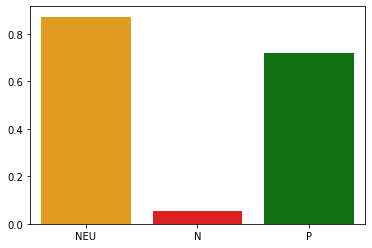

In [ ]:
text = "el otro dia vi una peli que no me terminó de convecer del todo pero de igual manera creo que la recomiendo"
classify_text_sentiment(text)

{'NEU': 0.881679356098175, 'N': 0.3312743604183197, 'P': 0.1988440454006195}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


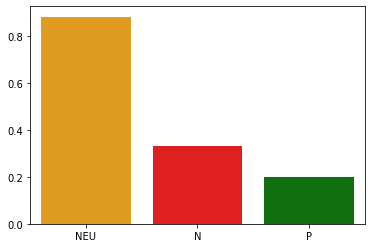

In [126]:
text = "no te dije que no queria"
classify_text_sentiment(text)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


{'NEU': 0.5245075821876526, 'N': 0.3382980227470398, 'P': 0.6411923170089722}


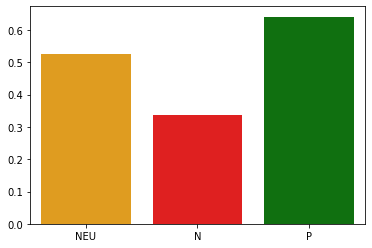

In [ ]:
text = "esto no es feo"
classify_text_sentiment(text)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


{'NEU': 0.24779300391674042, 'N': 0.9835528135299683, 'P': 0.04932866618037224}


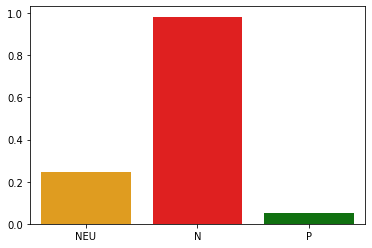

In [ ]:
text = "esto es feo"
classify_text_sentiment(text)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text_withtout_stops.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


{'NEU': 0.9090158939361572, 'N': 0.33561161160469055, 'P': 0.26876431703567505}


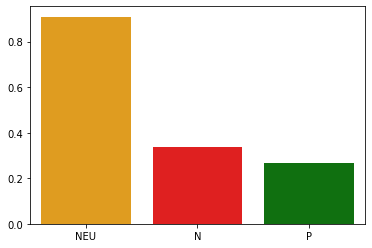

In [ ]:
text = "javier no me termina de cerrar"
classify_text_sentiment(text)